## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms

#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

ERROR! Session/line number was not unique in database. History logging moved to new session 158


## Load and prepare data 

In [2]:
# Normalization values - using imagenet values 
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)

transform =  transforms.Compose( 
    [
    transforms.ToTensor(),
    transforms.Resize((224,224)), #224x224 px images
    transforms.Normalize((imagenet_means),(imagenet_stds)) #set mean and std

    ]
)

#load dataset
data_folder_path = 'trainval'
trainval_dataset = torchvision.datasets.ImageFolder(data_folder_path, transform = transform)

In [3]:
num_classes = len(trainval_dataset.classes)
class_labels = trainval_dataset.classes

In [4]:
train_portion = 0.8
val_portion = 0.2

# Created indexes 0-999
all_idxes = np.arange(len(trainval_dataset))
# Stores all labels as targets
all_targets = trainval_dataset.targets

#Split the data into the  predifined portions
train_idx, val_idx = train_test_split(all_idxes, train_size=train_portion, stratify = all_targets, random_state = 0)

train_dataset = torch.utils.data.Subset(trainval_dataset, train_idx)
val_dataset = torch.utils.data.Subset(trainval_dataset, val_idx)

print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of val dataset: {len(val_dataset)}')

Size of train dataset: 800
Size of val dataset: 200


In [5]:
batch_size = 8

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [6]:
train_labels = [ data[1] for data in train_dataset]
val_labels = [ data[1] for data in val_dataset]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5561913..1.8172337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48334622..1.81889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.512071..1.624159].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55895185..1.2509258].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5589522..1.5767567].


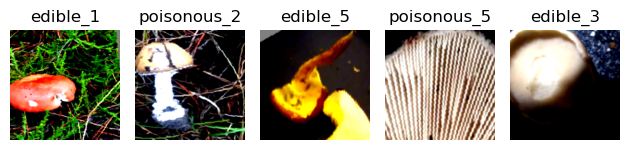

In [7]:
### Add more transforms in here
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    transforms.RandomResizedCrop(224)

])
class_labels = trainval_dataset.classes
#visualise the train dataset with these transforms
data = next(iter(trainloader))
fig, ax = plt.subplots(1, 5)
for idx in range(5):
    im = data[0][idx]
    lbl = data[1][idx]
    im = train_transform(im)
    train_image = (im.numpy())/2 + 0.5
    label = class_labels[lbl]
    train_image = np.moveaxis(train_image, 0, 2)
    ax[idx].imshow(train_image)
    ax[idx].set_axis_off()
    ax[idx].set_title(label.split('-')[-1])
plt.tight_layout()
plt.show()


In [8]:
lbls, counts = np.unique(train_labels, return_counts = True)

weighting = torch.DoubleTensor([1/x for x in counts])
sample_weights = weighting[train_labels]

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(train_dataset))
balanced_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler = sampler)

## Dino

In [9]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available

In [10]:
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino.eval()
dino.to(device)

Using cache found in /tmp/.cache/torch/hub/facebookresearch_dinov2_main
/tmp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/tmp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/tmp/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [11]:
for data in trainloader:
    inputs, labels = data

    inputs = inputs.to(device)
    
    feature = dino(inputs)

    print(feature.size())
    break

torch.Size([8, 384])


In [12]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(384, 10) # (input dimension, output dimension)
       
        
    def forward(self, x):
        y = self.fc(x)
       
        return y

Epoch 1 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.26it/s]


Saving model at epoch 1 with accuracy 65.5%


Epoch 2 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.44it/s]


Saving model at epoch 2 with accuracy 68.5%


Epoch 3 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


Saving model at epoch 3 with accuracy 74.5%


Epoch 4 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.45it/s]


Saving model at epoch 4 with accuracy 76.0%


Epoch 5 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


Saving model at epoch 5 with accuracy 78.0%


Epoch 9 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 10.74it/s]


Saving model at epoch 9 with accuracy 79.5%


Epoch 10 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.07it/s]


Saving model at epoch 10 with accuracy 80.0%


Epoch 20 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 11.40it/s]


Saving model at epoch 20 with accuracy 84.0%


Epoch 30 - validating phase: 100%|██████████| 25/25 [00:02<00:00, 10.85it/s]


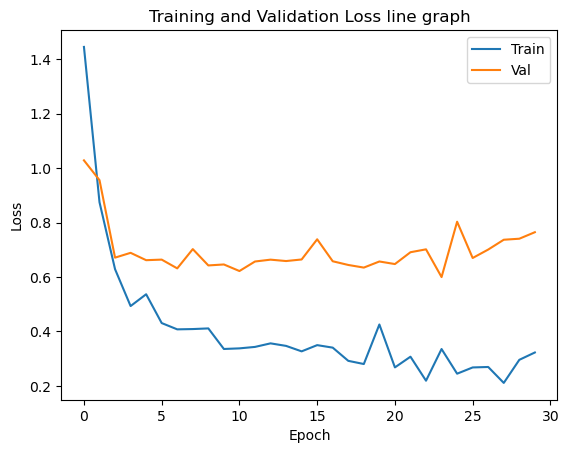

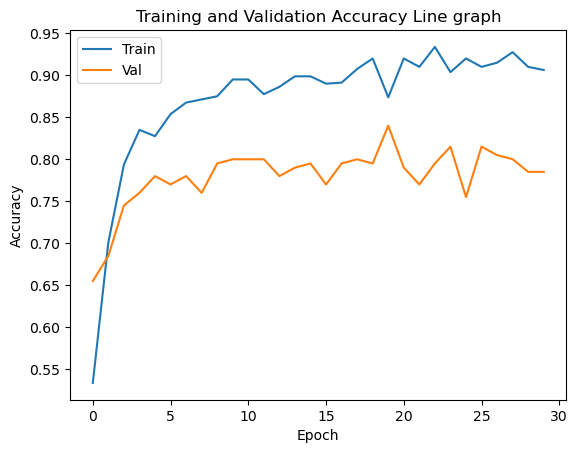

In [13]:
#lets train linear classifier with dyno embeddings

torch.manual_seed(0)

#any hyperparameters
lr = 0.001
total_epochs = 30


# #Step 1: Initialise the model.
linear = LinearClassifier()##############

# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()

# Step 3: Initialise the SGD optimizer.
optimizer = optim.SGD(linear.parameters(), lr=lr, momentum=0.9)##########

#Step 4: For n epochs (e.g. loss converged/stops changing)
total_train_loss = []
total_train_acc = []
best_acc = 0
total_val_loss = []
total_val_acc = []


for epoch in range(total_epochs):    
    #Step 4A: Put the model in "train" mode
    linear.train() #########

    #Step 4B: Training loop: For all batches in the training dataset
    train_loss = []
    correct = 0
    total = 0
    #####################UPDATED LINE##########################################
    for i, data in  tqdm.tqdm(enumerate(balanced_trainloader, 0), total = len(balanced_trainloader), desc = f'Epoch {epoch+1} - training phase'):
        inputs, labels = data

        inputs = train_transform(inputs)
        
        inputs = inputs.to(device)
        #labels = labels.to(device)

        optimizer.zero_grad()

        feature = dino(inputs)###########

        feature = feature.cpu() ######### putting on the cpu 
        
        outputs = linear(feature)#########
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        train_loss += [loss.cpu().item()]
        
        predicted = torch.argmax(outputs, axis = 1)
        
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total

    total_train_loss += [mean_train_loss]
    total_train_acc += [train_accuracy]
    
    #Step 4C: Put the model in "eval" mode
    linear.eval()

    #Step 4D: Validation loop: For all batches in the validation dataset
    val_loss = []
    correct = 0
    total = 0

    for i, data in  tqdm.tqdm(enumerate(valloader, 0), total = len(valloader), desc = f'Epoch {epoch+1} - validating phase'):
        inputs , labels = data

        inputs = inputs.to(device)
        #labels = labels.to(device)

        feature = dino(inputs)###########
        feature = feature.cpu() ######### putting on the cpu 

        
        outputs = linear(feature)

        loss = criterion(outputs,labels) # This calculates the loss for one batch
        val_loss.append(loss.cpu().item())

        predicted =torch.argmax(outputs, axis = 1)

        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    val_accuracy = correct/total
    mean_val_loss = np.mean(val_loss)
    
    
    total_val_loss += [mean_val_loss]
    total_val_acc += [val_accuracy]

    
    #getting model with highest accuracy 
    if val_accuracy > best_acc:
        #save the model
        torch.save(linear.state_dict(), f'Linear_Dino_LR{lr}.pth')
        print(f'Saving model at epoch {epoch + 1} with accuracy {val_accuracy * 100}%')
        #update the best accuracy
        best_acc = val_accuracy
    

plt.plot(total_train_loss, label = 'Train')
plt.plot(total_val_loss, label = 'Val')
plt.title('Training and Validation Loss line graph')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(total_train_acc, label = 'Train')
plt.plot(total_val_acc, label = 'Val')
plt.title('Training and Validation Accuracy Line graph')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [14]:
best_acc

0.84

In [15]:
val_samples = 20


all_idxes = np.arange(len(trainval_dataset))
all_targets = np.array(trainval_dataset.targets)

train_idxes = []
val_idxes = []

for i in range(num_classes):
    #Get all of the observations that belong to that class
    cls_mask = all_targets == i
    cls_idxes = all_idxes[cls_mask]

    full_size = len(cls_idxes)
    val_portion = val_samples / full_size

    val_idx, train_idx = train_test_split(cls_idxes, train_size= val_portion,  random_state = 0)
    train_idxes += train_idx.tolist()
    val_idxes += val_idx.tolist()


    train_dataset = torch.utils.data.Subset(trainval_dataset, train_idxes)
    val_dataset = torch.utils.data.Subset(trainval_dataset, val_idxes)


# train_idx, val_idx = train_test_split(all_idxes, train_size=(len(trainval_dataset) - val_samples), stratify = all_targets, random_state = 0)


# train_dataset = torch.utils.data.Subset(trainval_dataset, train_idx)
# val_dataset = torch.utils.data.Subset(trainval_dataset, val_idx)


print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of val dataset: {len(val_dataset)}')

Size of train dataset: 800
Size of val dataset: 200


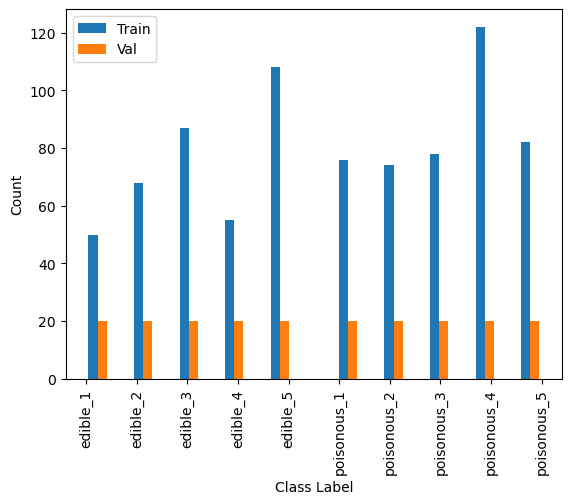

In [16]:
num_classes = len(trainval_dataset.classes)
class_labels = trainval_dataset.classes

train_labels = [data[1] for data in train_dataset]
val_labels = [data[1] for data in val_dataset]

plt.hist([train_labels, val_labels], bins = 20, label = ['Train', 'Val']) 
plt.xlabel('Class Label')
plt.legend()
plt.xticks([i for i in range(num_classes)], class_labels, rotation=90)
plt.ylabel('Count')
plt.show()

In [17]:
model = torchvision.models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load(f'Linear_Dino_LR{lr}.pth', map_location = 'cpu'))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                          shuffle=False, num_workers = 2)

In [19]:
gt = []
pred = []

for data in tqdm.tqdm(valloader, total = len(valloader)):
    inputs, labels = data

    outputs = model(inputs)

    predicted = torch.argmax(outputs, axis = 1)
    pred += predicted.cpu().tolist()
    gt += labels.cpu().tolist()

100%|██████████| 200/200 [00:04<00:00, 48.49it/s]


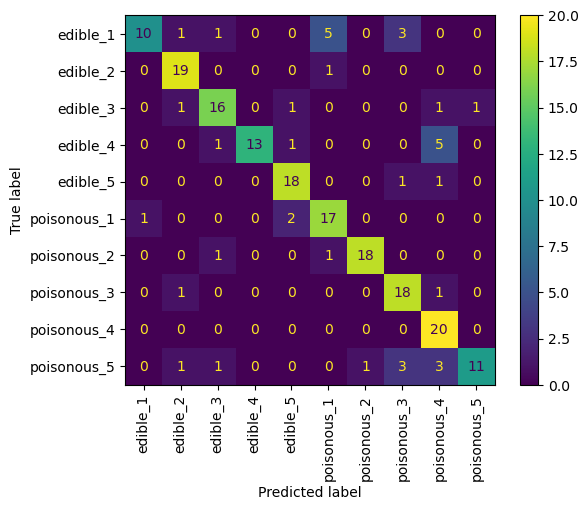

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(gt, pred, display_labels = val_dataset.dataset.classes, xticks_rotation = 'vertical')

In [21]:
class_names = val_dataset.dataset.classes

gt = []
pred = []

for data in tqdm.tqdm(valloader, total = len(valloader)):
    inputs, labels = data

    outputs = model(inputs)

    predicted = torch.argmax(outputs, axis = 1)


    gt_name = class_names[labels]

    if 'poisonous' in gt_name:
        gt += [0] # assign a label of 0 it is poisonous
    else:
        gt += [1] # not poisonoous assign a label of 1

    pred_name = class_names[predicted] 
    
    if 'poisonous' in pred_name:
        pred += [0] 
    else:
        pred += [1] 

100%|██████████| 200/200 [00:03<00:00, 52.43it/s]


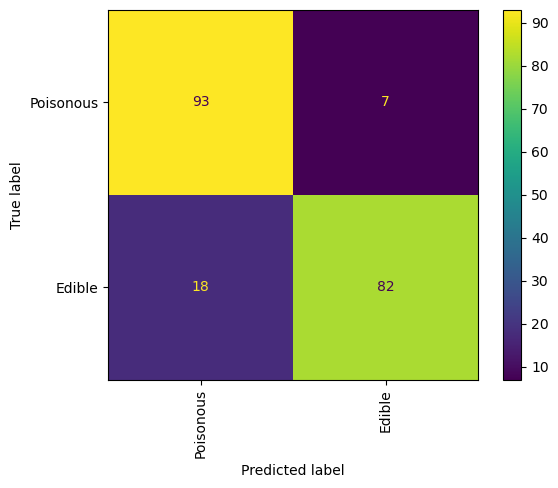

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(gt, pred, display_labels = ['Poisonous', 'Edible'], xticks_rotation = 'vertical')

In [23]:
from sklearn.metrics import classification_report,precision_score, recall_score

In [24]:
print(classification_report(gt,pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       100
           1       0.92      0.82      0.87       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200

